
# Project 2: Investigation of No Show Patients in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> Patients in Brazil make appointments at a medical care facility, but about 20% of them do not show up. This dataset contains information about these patients that may help indicate which ones won't make it to their scheduled appointment. If we can identify the characteristics of patients that tend not to show up, medical facilities can take actions to help prevent these patients from not showing up and to make the most out of their schedule.

In [301]:
# Imports

# Dataframes and Computing
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> This section includes loading in the data, checking for nulls, dupes, and inconsistencies, and the respective cleaning steps to prepare the data for engineering and analysis.

### General Properties

In [302]:
# Load the csv into the dataframe df
df = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")

# Examine the shape
print("Shape: ", df.shape)

# Explore the first few rows of data
df.head()

Shape:  (110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Double Check Data-Types

In [303]:
# What are the dtypes?
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [304]:
# Check the more specific data type associated with each column:
# dtypes is limited in that it doesn't show the exact object type
# Print out the exact data type of the first item in each column
for c in df.columns:
    print(c, type(df[c][0]))
    
# Looks like there are some data types to adjust
# Need to convert the following:
## PatientId from float to string
## AppointmentID from float to string
## ScheduledDay from string to datetime
## AppointmentDay from string to datetime
## No-show from string to binary or true/false

PatientId <class 'numpy.float64'>
AppointmentID <class 'numpy.int64'>
Gender <class 'str'>
ScheduledDay <class 'str'>
AppointmentDay <class 'str'>
Age <class 'numpy.int64'>
Neighbourhood <class 'str'>
Scholarship <class 'numpy.int64'>
Hipertension <class 'numpy.int64'>
Diabetes <class 'numpy.int64'>
Alcoholism <class 'numpy.int64'>
Handcap <class 'numpy.int64'>
SMS_received <class 'numpy.int64'>
No-show <class 'str'>


### Reload data with specified data types

In [305]:
# Re-load data with desired dtypes and dates
dtype_dict = {'PatientId': str, 'AppointmentID': str}
dates_list=['ScheduledDay','AppointmentDay']
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv',\
                 dtype=dtype_dict,\
                 date_parser = pd.core.tools.datetimes.to_datetime,\
                 parse_dates=dates_list)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [306]:
# Check that the data types and dates are correct
for c in df.columns:
    print(c, type(df[c][0]))

PatientId <class 'str'>
AppointmentID <class 'str'>
Gender <class 'str'>
ScheduledDay <class 'pandas._libs.tslibs.timestamps.Timestamp'>
AppointmentDay <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Age <class 'numpy.int64'>
Neighbourhood <class 'str'>
Scholarship <class 'numpy.int64'>
Hipertension <class 'numpy.int64'>
Diabetes <class 'numpy.int64'>
Alcoholism <class 'numpy.int64'>
Handcap <class 'numpy.int64'>
SMS_received <class 'numpy.int64'>
No-show <class 'str'>


### Nulls, dupes, and inconsistencies

In [307]:
# Check for any null values in each column
df.isna().sum()

# Luckily there doesn't appear to be any missing data

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [308]:
# Are there any duplicated rows?
df[df.duplicated()]

# There are no duplicate rows

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [309]:
# Rename the 'No-show' column to eliminate the hyphen
df.rename(columns={"No-show": "NoShow"}, inplace=True)

### Observe basic summary statistics

In [310]:
# View basic stats about the numeric columns
df.describe()

# How can age be negative?
# What are the rankings of Handcap?
# Nothing else seems out of place

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [311]:
# How many ages are negative
df[df.Age<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow
99832,465943158731293,5775010,F,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No


In [312]:
# How many handcap examples are there?
df.Handcap.value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

### Unique Values of Each Column

In [313]:
# Unique Values for Each Feature
print('Age:',sorted(df.Age.unique()))
print('Gender:',df.Gender.unique())
print("Neighbourhood",df.Neighbourhood.unique())
print('Scholarship:',df.Scholarship.unique())
print('Hipertension:',df.Hipertension.unique())
print('Diabetes:',df.Diabetes.unique())
print('Alcoholism:',df.Alcoholism.unique())
print('Handcap:',df.Handcap.unique())
print('SMS_received:',df.SMS_received.unique())

Age: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
Gender: ['F' 'M']
Neighbourhood ['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIEIRAS'
 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM' 'JARDIM CAMBURI' 'MARIA ORTIZ'
 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA' 'ILHA DE SANTA MARIA'
 'JUCUTUQUARA' 'MONTE BELO' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO' 'BELA VISTA'
 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ' 'UNIVERSITÁRIO'
 'SÃ

### No Show vs Show Patients

In [314]:
# Recall the naming convention
# No means the patient made their appointment
# Yes mean the patient was a no-show
# Most patients showed to their appointments (88,208)
df['NoShow'].value_counts()

No     88208
Yes    22319
Name: NoShow, dtype: int64

In [315]:
# Percentage of No Shows
print('Percentage No Show: ', 100*df[df['NoShow']=='Yes'].shape[0]/df.shape[0])
print('Percentage Show: ', 100*df[df['NoShow']=='No'].shape[0]/df.shape[0])

Percentage No Show:  20.193255946510806
Percentage Show:  79.8067440534892


### Data Cleaning

In [316]:
# Create a numeric column version of the No Show column
# No == 0
# Yes == 1
df['NoShowNum'] = np.where(df.NoShow=='No',0,1)

In [317]:
# Remove Rows where Age < 0
df = df[df.Age>=0]

In [318]:
# Create adult column to indicate above or below age 18
# 18+ == adult (yes)
# <18 == child (no)
df['Adult'] = np.where(df.Age < 18, 'No', 'Yes')

In [319]:
# Separate the scheduled hour from the scheduled datetime
df['ScheduledHour'] = df['ScheduledDay'].map(lambda x: x.time().hour)

In [320]:
# Set granularity of both dates to match - both will be date only, ignore the time
df['ScheduledDay'] = df['ScheduledDay'].map(lambda x: x.date())
df['AppointmentDay'] = df['AppointmentDay'].map(lambda x: x.date()) 

In [321]:
# Calculate the number of days before an appointment, the appointment was scheduled
df['DayDelta'] = ( (df.AppointmentDay - df.ScheduledDay)).map(lambda x: x.days)
df[['PatientId','ScheduledDay', 'AppointmentDay', 'DayDelta', 'NoShow']].head(10)

,PatientId,ScheduledDay,AppointmentDay,DayDelta,NoShow
0,29872499824296,2016-04-29,2016-04-29,0,No
1,558997776694438,2016-04-29,2016-04-29,0,No
2,4262962299951,2016-04-29,2016-04-29,0,No
3,867951213174,2016-04-29,2016-04-29,0,No
4,8841186448183,2016-04-29,2016-04-29,0,No
5,95985133231274,2016-04-27,2016-04-29,2,No
6,733688164476661,2016-04-27,2016-04-29,2,Yes
7,3449833394123,2016-04-27,2016-04-29,2,Yes
8,56394729949972,2016-04-29,2016-04-29,0,No
9,78124564369297,2016-04-27,2016-04-29,2,No


In [322]:
# Remove the rows where the day delta is negative
# The schedule day can't be after the appointment day
df = df[df['DayDelta']>=0]

In [323]:
# Separate out the week day from the scheduled and appointment datetimes
df['SchedDay'] = df.ScheduledDay.apply(lambda x: x.weekday())
df['ApptDay'] = df.AppointmentDay.apply(lambda x: x.weekday())

In [324]:
# Visualize the first few rows of the cleaned and adjusted dataframe
print('New Dataframe shape: ', df.shape)
df.head()

New Dataframe shape:  (110521, 20)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,NoShow,NoShowNum,Adult,ScheduledHour,DayDelta,SchedDay,ApptDay
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,Yes,18,0,4,4
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,Yes,16,0,4,4
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,Yes,16,0,4,4
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,No,17,0,4,4
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,Yes,16,0,4,4


<a id='eda'></a>
## Exploratory Data Analysis


### What factors indicate that a patient may not show up for their appointment?
Detecting no-show's could help doctor's offices reallocate resources and plan appropriately for ups and downs in their schedules.
For each patient characteristic we will: 
1. Visualize overall distributoins by unique values
2. Then compare show to no show within each feature category
3. And perform a student's t-test to determine whether a feature creates a significant difference (positively or negatively) in the ratio of show to no show patients

### Patient Characteristics

#### Gender

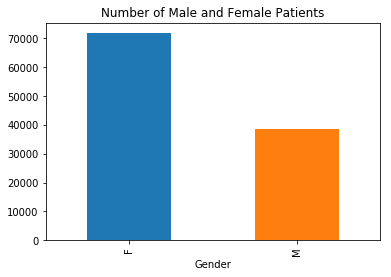

In [325]:
df.groupby('Gender')['NoShow'].count().plot.bar();
plt.title("Number of Male and Female Patients");

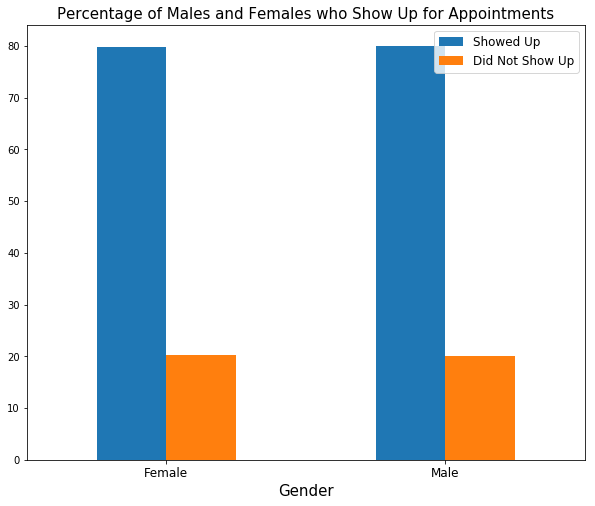

In [335]:
groups = df.groupby(['Gender', 'NoShow'])['NoShow'].count()
groups = groups.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
ax = groups.unstack().plot.bar(figsize=(10,8));
plt.legend(['Showed Up', 'Did Not Show Up'], fontsize=12);
ax.set_xticklabels(['Female','Male'], rotation=0, fontsize=12);
plt.title('Percentage of Males and Females who Show Up for Appointments', fontsize=15);
plt.xlabel('Gender', fontsize=15);

In [327]:
# Null Hypothesis: female patients 
# are just as likely not to show up to appointments as males
group1 = df[df['Gender'] == 'F']['NoShowNum'].astype(float)
group2 = df[df['Gender'] == 'M']['NoShowNum'].astype(float)

t, p = ttest_ind(group1, group2)
if p <= 0.05:
    print('Reject the null hypothesis; p==', p)
else:
    print('Do not reject the null hypothesis; p==', p)

Do not reject the null hypothesis; p== 0.169559292837


#### Age

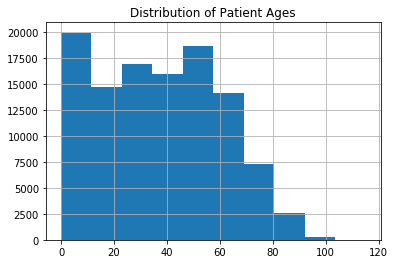

In [328]:
df.Age.hist();
plt.title('Distribution of Patient Ages');

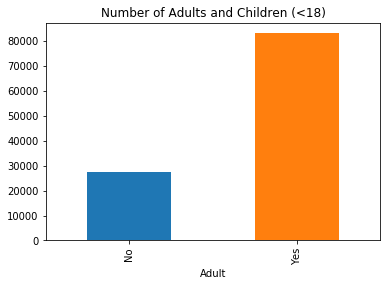

In [329]:
df.groupby('Adult')['NoShow'].count().plot.bar();
plt.title("Number of Adults and Children (<18)");

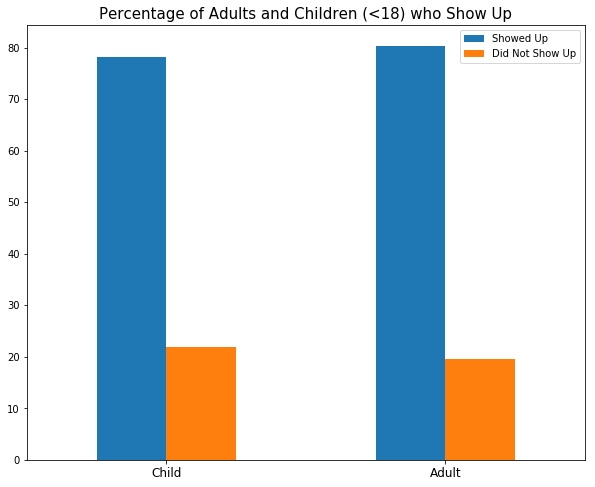

In [331]:
groups = df.groupby(['Adult', 'NoShow'])['NoShow'].count()
groups = groups.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
ax = groups.unstack().plot.bar(figsize=(10,8));
plt.legend(['Showed Up', 'Did Not Show Up']);
ax.set_xticklabels(['Child', 'Adult'], rotation=0, fontsize=12);
plt.title("Percentage of Adults and Children (<18) who Show Up", fontsize=15);
ax.set_xlabel('');

In [228]:
# Null Hypothesis: patients who are adults 
# are just as likely not to show up to appointments as those who children
group1 = df[df['Adult'] == 'No']['NoShowNum'].astype(float)
group2 = df[df['Adult'] == 'Yes']['NoShowNum'].astype(float)

t, p = ttest_ind(group1, group2)
if p <= 0.05:
    print('Reject the null hypothesis; p==', p)
else:
    print('Do not reject the null hypothesis; p==', p)

Reject the null hypothesis; p== 4.20989435091e-16


#### Neighborhood

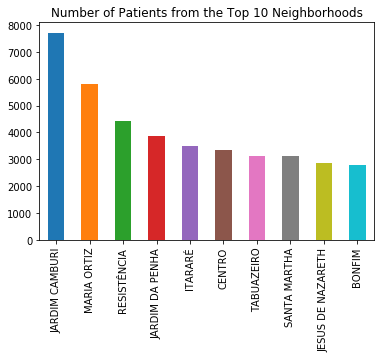

In [260]:
# Top 10 Represented Neighborhoods
df['Neighbourhood'].value_counts().sort_values(ascending=False)[0:10].plot.bar();
plt.title("Number of Patients from the Top 10 Neighborhoods");

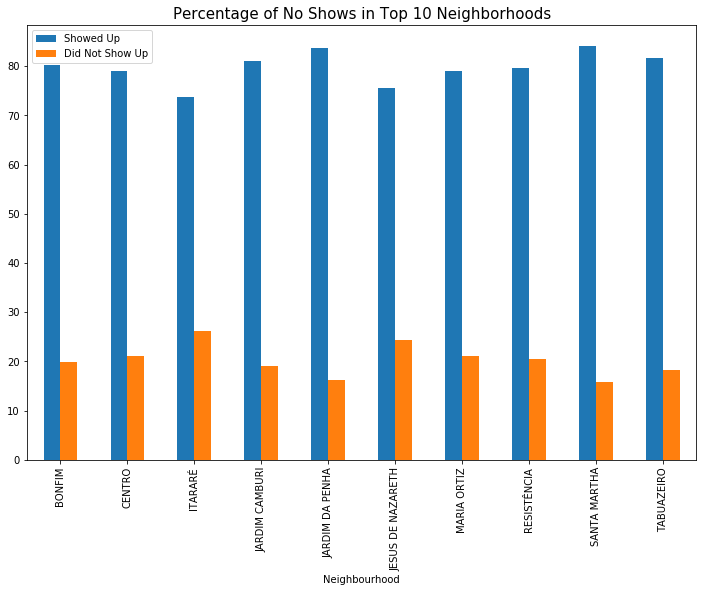

In [155]:
top10 = df['Neighbourhood'].value_counts().sort_values(ascending=False)[0:10].index
groups = df[df.Neighbourhood.isin(top10)].groupby(['Neighbourhood', 'NoShow'])['NoShow'].count()
groups = groups.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
groups.unstack().plot.bar(figsize=(12,8));
plt.legend(['Showed Up', 'Did Not Show Up']);
plt.title("Percentage of No Shows in Top 10 Neighborhoods", fontsize=15);

#### Scholarship

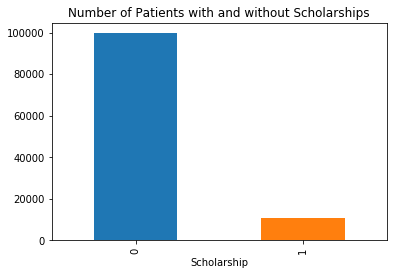

In [262]:
df.groupby('Scholarship')['NoShow'].count().plot.bar();
plt.title("Number of Patients with and without Scholarships");

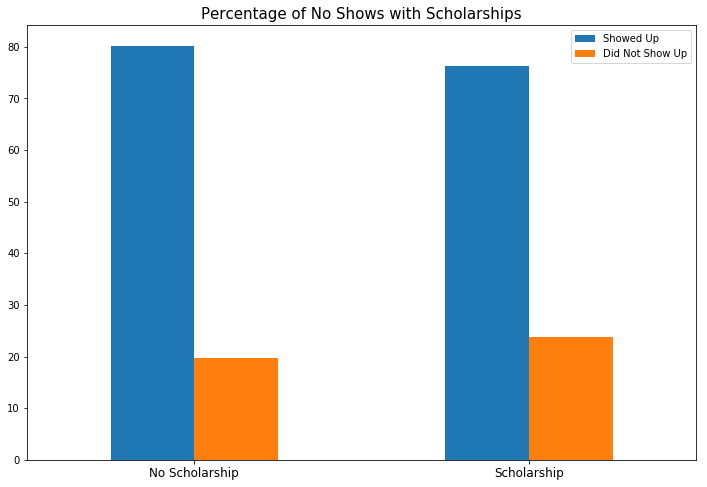

In [298]:
groups = df.groupby(['Scholarship', 'NoShow'])['NoShow'].count()
groups = groups.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
ax = groups.unstack().plot.bar(figsize=(12,8));
plt.legend(['Showed Up', 'Did Not Show Up']);
ax.set_xticklabels(['No Scholarship','Scholarship'], rotation=0, fontsize=12);
plt.title("Percentage of No Shows with Scholarships", fontsize=15);
ax.set_xlabel('');

In [218]:
# Null Hypothesis: patients who receive scholarships 
# are just as likely not to show up to appointments as those who don't
group1 = df[df['Scholarship'] == 0]['NoShowNum'].astype(float)
group2 = df[df['Scholarship'] == 1]['NoShowNum'].astype(float)

t, p = ttest_ind(group1, group2)
if p <= 0.05:
    print('Reject the null hypothesis; p==', p)
else:
    print('Do not reject the null hypothesis; p==', p)

Reject the null hypothesis; p== 3.0721328672e-22


### Patient Conditions

#### Hipertension

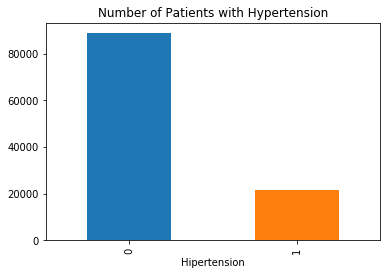

In [264]:
df.groupby('Hipertension')['NoShow'].count().plot.bar();
plt.title("Number of Patients with Hypertension");

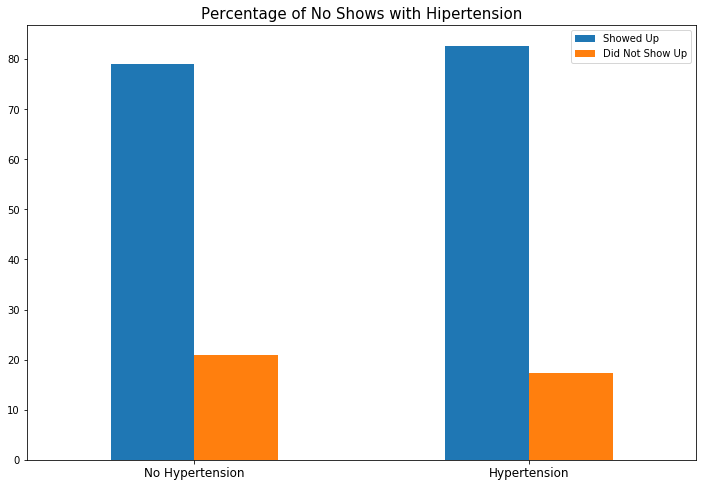

In [296]:
groups = df.groupby(['Hipertension','NoShow'])['NoShow'].count()
groups = groups.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
ax = groups.unstack().plot.bar(figsize=(12,8));
plt.legend(['Showed Up', 'Did Not Show Up']);
ax.set_xticklabels(['No Hypertension','Hypertension'], rotation=0, fontsize=12);
plt.title("Percentage of No Shows with Hipertension", fontsize=15);
ax.set_xlabel('');

In [216]:
# Null Hypothesis: patients who have hypertension
# are just as likely not to show up to appointments as those who don't
group1 = df[df['Hipertension'] == 0]['NoShowNum'].astype(float)
group2 = df[df['Hipertension'] == 1]['NoShowNum'].astype(float)

t, p = ttest_ind(group1, group2)
if p <= 0.05:
    print('Reject the null hypothesis; p==', p)
else:
    print('Do not reject the null hypothesis; p==', p)

Reject the null hypothesis; p== 1.92191181927e-32


#### Diabetes

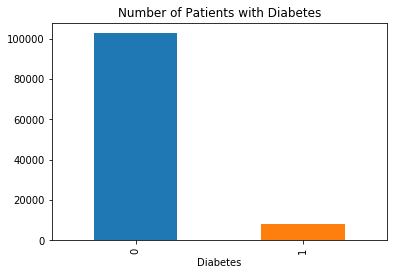

In [266]:
df.groupby('Diabetes')['NoShow'].count().plot.bar();
plt.title("Number of Patients with Diabetes");

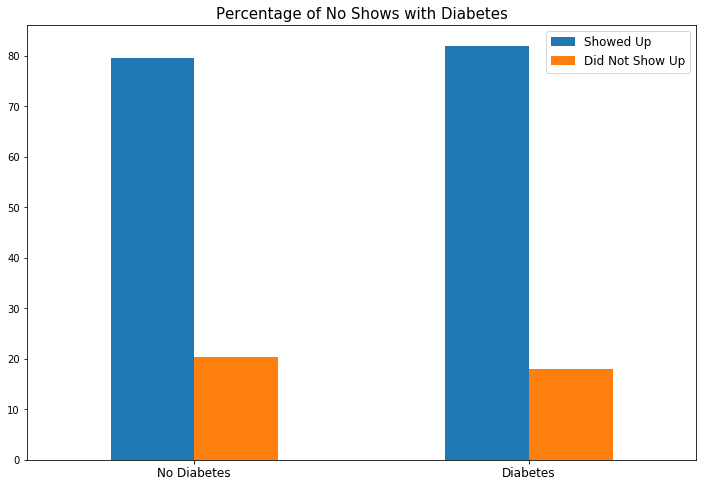

In [294]:
groups = df.groupby(['Diabetes','NoShow'])['NoShow'].count()
groups = groups.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
ax = groups.unstack().plot.bar(figsize=(12,8));
plt.legend(['Showed Up', 'Did Not Show Up'], fontsize=12);
ax.set_xticklabels(['No Diabetes','Diabetes'], rotation=0, fontsize=12);
plt.title("Percentage of No Shows with Diabetes", fontsize=15);
ax.set_xlabel('');

In [215]:
# Null Hypothesis: patients who receive text messages 
# are just as likely not to show up to appointments as those who don't
group1 = df[df['Diabetes'] == 0]['NoShowNum'].astype(float)
group2 = df[df['Diabetes'] == 1]['NoShowNum'].astype(float)

t, p = ttest_ind(group1, group2)
if p <= 0.05:
    print('Reject the null hypothesis; p==', p)
else:
    print('Do not reject the null hypothesis; p==', p)

Reject the null hypothesis; p== 4.67171460559e-07


#### Alcoholism

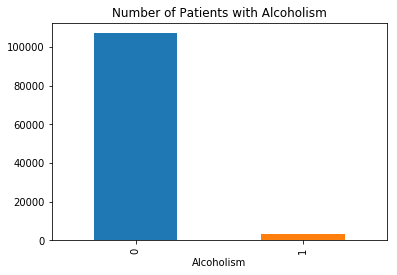

In [268]:
df.groupby('Alcoholism')['NoShow'].count().plot.bar();
plt.title("Number of Patients with Alcoholism");

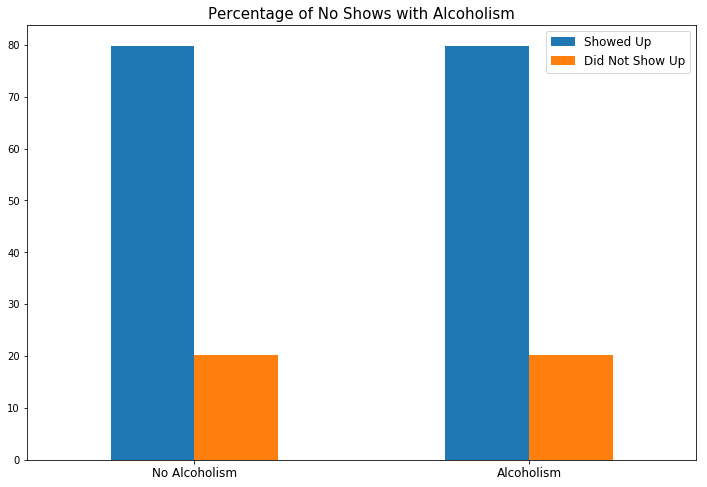

In [340]:
groups = df.groupby(['Alcoholism','NoShow'])['NoShow'].count()
groups = groups.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
ax = groups.unstack().plot.bar(figsize=(12,8));
plt.legend(['Showed Up', 'Did Not Show Up'], fontsize=12);
plt.title("Percentage of No Shows with Alcoholism", fontsize=15);
ax.set_xticklabels(['No Alcoholism','Alcoholism'], rotation=0, fontsize=12);
ax.set_xlabel('');

In [212]:
# Null Hypothesis: patients who receive text messages 
# are just as likely not to show up to appointments as those who don't
group1 = df[df['Alcoholism'] == 0]['NoShowNum'].astype(float)
group2 = df[df['Alcoholism'] == 1]['NoShowNum'].astype(float)

t, p = ttest_ind(group1, group2)
if p <= 0.05:
    print('Reject the null hypothesis; p==', p)
else:
    print('Do not reject the null hypothesis; p==', p)

Do not reject the null hypothesis; p== 0.952034061998


#### Handcap

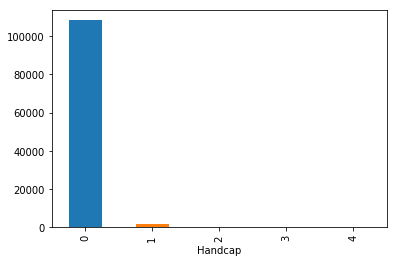

In [336]:
df.groupby(['Handcap'])['NoShow'].count().plot.bar();

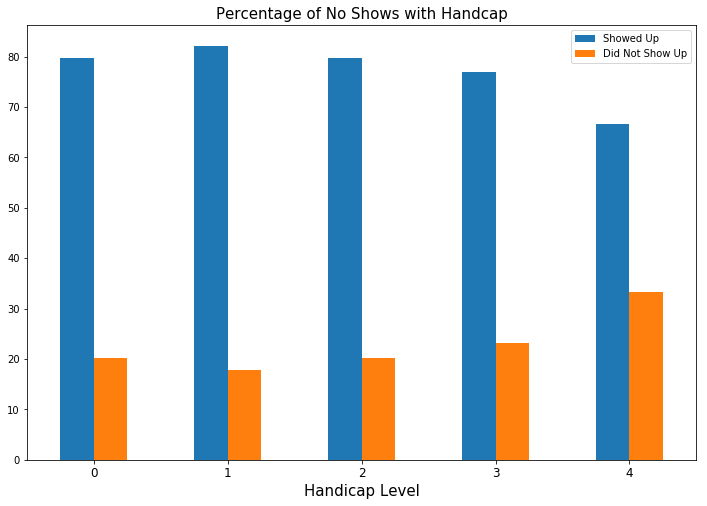

In [345]:
groups = df.groupby(['Handcap','NoShow'])['NoShow'].count()
groups = groups.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
ax = groups.unstack().plot.bar(figsize=(12,8));
plt.legend(['Showed Up', 'Did Not Show Up']);
ax.set_xticklabels(['0','1','2','3','4'], rotation=0, fontsize=12);
plt.title("Percentage of No Shows with Handcap", fontsize=15);
plt.xlabel('Handicap Level',fontsize=15);

### Scheduling Scenario Characteristics

#### SMS_Recieved

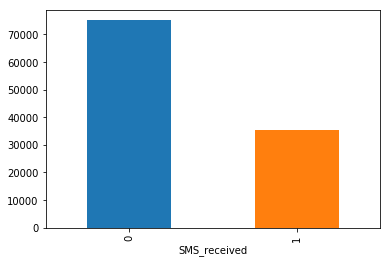

In [346]:
df.groupby('SMS_received')['NoShow'].count().plot.bar();

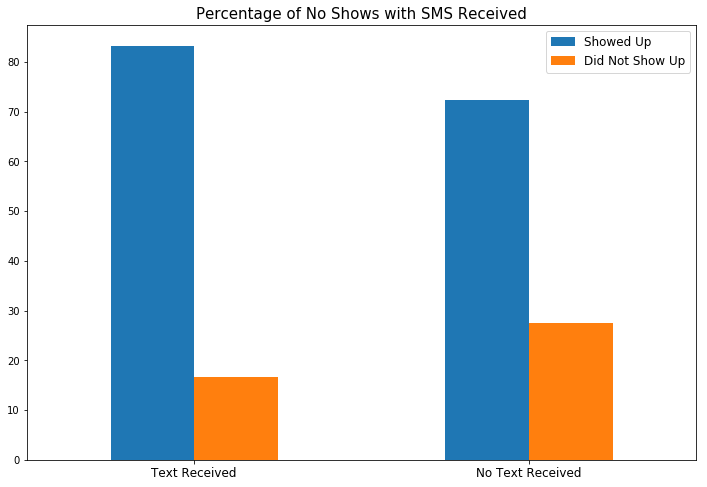

In [351]:
groups = df.groupby(['SMS_received','NoShow'])['NoShow'].count()
groups = groups.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
ax = groups.unstack().plot.bar(figsize=(12,8));
plt.legend(['Showed Up', 'Did Not Show Up'], fontsize=12);
ax.set_xticklabels(['Text Received','No Text Received'], rotation=0, fontsize=12);
plt.title("Percentage of No Shows with SMS Received", fontsize=15);
ax.set_xlabel('');

In [214]:
# Null Hypothesis: patients who receive text messages 
# are just as likely not to show up to appointments as those who don't
group1 = df[df['SMS_received'] == 0]['NoShowNum'].astype(float)
group2 = df[df['SMS_received'] == 1]['NoShowNum'].astype(float)

t, p = ttest_ind(group1, group2)
if p <= 0.05:
    print('Reject the null hypothesis; p==', p)
else:
    print('Do not reject the null hypothesis; p==', p)

Reject the null hypothesis; p== 0.0


#### ScheduledHour

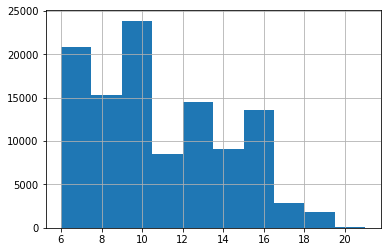

In [352]:
df.ScheduledHour.hist();

#### DayDelta

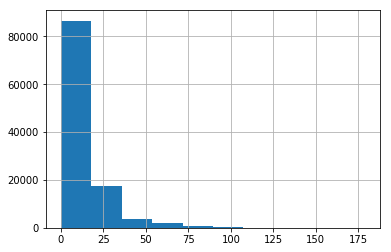

In [353]:
df.DayDelta.hist();

#### SchedDay

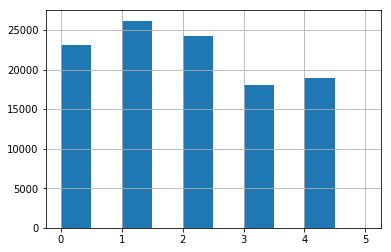

In [354]:
df.SchedDay.hist();

#### ApptDay

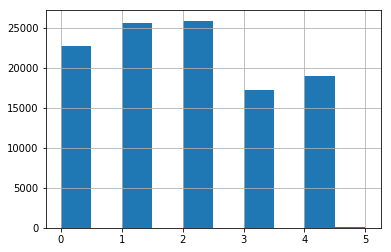

In [355]:
df.ApptDay.hist();

<a id='conclusions'></a>
## Conclusions

### Overall, there are a few main features that indicate that a patient is more likely to be a "no show". The following features have statistically significant differences in proportions of no shows to patients who do show up:
* **Gender:** There is no significant difference in no shows between male and female patients
* **Adult or Child:** Patients under 18 are more likely to be no shows
* **Scholarship:** Patients that receive scholarships are more likely to be no shows
* **Hypertension:** Patients without hypertension are more likely to be no shows
* **Diabetes:** Patients without diabetes are more likely to be no shows
* **Alcoholism:** There is no difference between patients with alcoholism and those without; the sample size of patients with the condition is very small though so it's difficult to draw a strict conclusion.
* **SMS Received:** Patients who receive a text message are more likely to be no shows

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [357]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0